In [1]:
from numpy.random import seed
seed(1010)

## Implementation in Scikit-Learn

![](https://www.evernote.com/l/AAGiYGcKcIxIaJ7sCg97K9JDtUO2dY9mywoB/image.png)

### Raw Text Data

<img src="https://www.evernote.com/l/AAFfAyDQQ1xGPLTIxT2hcUSLrHuQDbYzsuYB/image.png" width=600px>

Here each line of text is a **document** and the collection of all lines of text is the **body**.

In [4]:
%sh curl --remote-name-all 'https://joshua-databricks.s3-us-west-2.amazonaws.com/text-data/pagesParsed.json'

% Total % Received % Xferd Average Speed Time Time Time Current
 Dload Upload Total Spent Left Speed

 0 0 0 0 0 0 0 0 --:--:-- --:--:-- --:--:-- 0
100 10.3M 100 10.3M 0 0 43.4M 0 --:--:-- --:--:-- --:--:-- 43.5M

In [5]:
dbutils.fs.cp("file:/databricks/driver/pagesParsed.json", "dbfs:/FileStore/tmp/pagesParsed.json")

Out[3]: True

In [43]:
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.getOrCreate()
wikiDF = spark.read.json("../data/pagesParsed.json")

wiki_df = wikiDF.toPandas()
# display(wiki_df) 

### Document-Term Matrix

<img src="https://www.evernote.com/l/AAFtjaKOjT5CYr5N_NPHKU6vpBWNnBgbWLIB/image.png" width=600px>

The Document-Term Matrix can be created using the `TfidfVectorizer` model [[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) in Scikit-Learn.

In [44]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

def no_number_preprocessor(tokens):
    r = re.sub('(\d)+', '', tokens.lower())
    # This alternative just removes numbers:
    # r = re.sub('(\d)+', '', tokens.lower())
    return r
  
vectorizer = TfidfVectorizer(stop_words='english', preprocessor=no_number_preprocessor)
bag_of_words = vectorizer.fit_transform(wiki_df.text)

### Singular Value Decomposition

<img src="https://www.evernote.com/l/AAEhTiOBufhPwKBx-Hgufx4XZ5XyfsCp8cMB/image.png" width=600px>

This can be achieved using the `TruncatedSVD` model. 

The function is named "truncated" SVD because it is capable of returning a dataset with fewer features than it is passed without significant loss of information, that is, it is great for reducing the dimension of data.

In [45]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
lsa = svd.fit_transform(bag_of_words)

### Topic Encoded Data

<img src="https://www.evernote.com/l/AAGhSgfs1nZHAIYfbnmNaHU8YjMV2i9fTmgB/image.png" width=600px>

The process transforms the original data into **topic-encoded data**.

Here, each row is indexed by its original text value. The data now consists of two columns of data one representing each of the two topics used to encode the **body**. Recall that this value of 2 was passed as an argument to the `TruncatedSVD` in the previous step.

In [73]:
import pandas as pd

topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_1", "topic_2"])
topic_encoded_df["title"] = wiki_df.title
topic_encoded_df["is_baseball"] = wiki_df.category == "Baseball"
display(topic_encoded_df[["title", "topic_1", "topic_2", "is_baseball"]])

ValueError: Shape of passed values is (1848, 20), indices imply (1848, 2)

## Byproducts of the Latent Semantic Analysis

The LSA generates a few byproducts that are useful for analysis:

- the **dictionary** or the set of all words that appear at least once in the **body**
- the **encoding matrix** used to encode the documents into topics. The **encoding matrix** can be studied to gain an understanding of the **topics** that are latent to the **body**.

#### The Dictionary

The dictionary is an attribute of a fit `TfidfVectorizer` model and can be accessed using the `.get_feature_names` method.

In [47]:
import random 
dictionary = vectorizer.get_feature_names()
for _ in range(10):
  print(random.choice(dictionary))

elba
confraternity
swann
cappelletti
woma
keiretsu
elektra
ryle
evertheless
harlequin


#### The Encoding Matrix

The **encoding matrix** is comprised of the `components_` stored as an attribute of a fit `TruncatedSVD`. We can examine this matrix to gain an understanding of the **topics** latent to the **body**.

**Note:** in `sklearn`, attributes of a model that are generated by a fitting process have a trailing underscore in their name as can be seen here with `svd.components_`.

In [48]:
encoding_matrix = pd.DataFrame(svd.components_,
                               index=['topic_1', 'topic_2'],
                               columns=dictionary).T
encoding_matrix["dictionary"] = dictionary
display(encoding_matrix.head())

,topic_1,topic_2,dictionary
_______,0.000190,0.000323,_______
__baseball,0.000089,0.000111,__baseball
a_,0.000211,0.000287,a_
aa,0.002082,0.002398,aa
aaa,0.002269,0.002774,aaa


#### Interpret The Encoding Matrix

What are the top words for each topic? What dimensions in word-space explain most of the variance in the data? 

To analyze this, we will need to look at the *absolute value* of the expression of each word in the topic.

In [49]:
display(encoding_matrix.sort_values('topic_1', ascending=False).head(20))

,topic_1,topic_2,dictionary
american,0.316776,-0.285724,american
died,0.286427,-0.339082,died
jazz,0.245747,-0.108479,jazz
baseball,0.222769,0.269622,baseball
composer,0.177629,-0.196012,composer
born,0.172118,-0.179936,born
pianist,0.158579,-0.175387,pianist
league,0.156629,0.189979,league
ball,0.141453,0.205173,ball
saxophonist,0.138060,-0.154190,saxophonist


In [50]:
display(encoding_matrix.sort_values('topic_2', ascending=False).head(20))

,topic_1,topic_2,dictionary
baseball,0.222769,0.269622,baseball
ball,0.141453,0.205173,ball
base,0.127467,0.189991,base
league,0.156629,0.189979,league
game,0.137942,0.179564,game
batter,0.089311,0.135794,batter
pitcher,0.089900,0.129789,pitcher
team,0.097103,0.123384,team
runner,0.066713,0.105300,runner
home,0.073519,0.095050,home


### Plot Topic Encoded Data

False
True


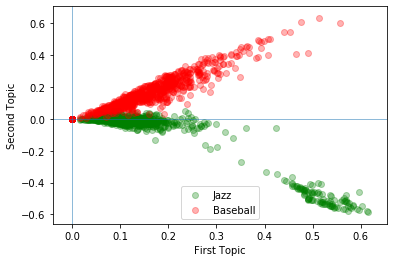

In [51]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for val in topic_encoded_df.is_baseball.unique():
  topic_1 = topic_encoded_df[topic_encoded_df.is_baseball == val]['topic_1'].values
  topic_2 = topic_encoded_df[topic_encoded_df.is_baseball == val]['topic_2'].values
  print(val)
  color = "red" if val else "green"
  label = "Baseball" if val else "Jazz"
  ax.scatter(topic_1, topic_2, c=color, alpha=0.3, label=label)
# made the colors represent different books

ax.set_xlabel('First Topic')
ax.set_ylabel('Second Topic')
ax.axvline(linewidth=0.5)
ax.axhline(linewidth=0.5)
ax.legend()

# display(fig)

In [52]:
topic_encoded_df.columns

Index(['topic_1', 'topic_2', 'title', 'is_baseball'], dtype='object')

## Document Clustering via Gaussian Mixture Model

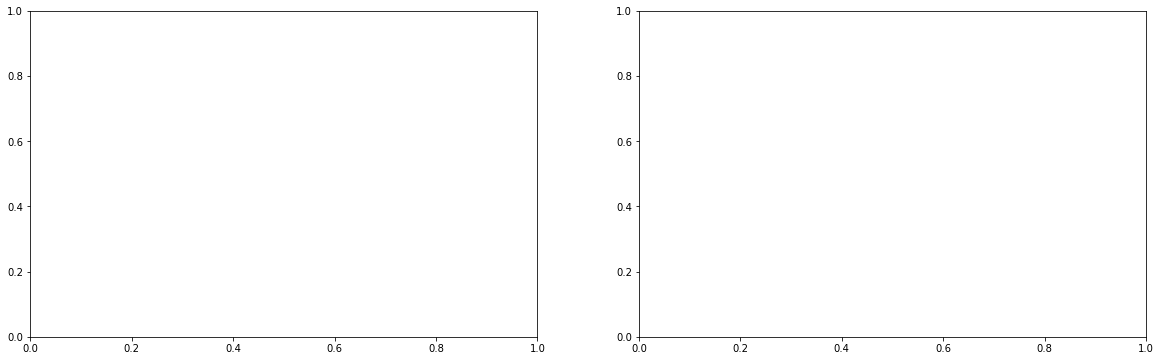

In [53]:
fig, ax = plt.subplots(1,2,figsize=(20,6))

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)
gmm.fit(topic_encoded_df[["topic_1", "topic_2"]])
labels = gmm.predict(topic_encoded_df[["topic_1", "topic_2"]])

No handles with labels found to put in legend.


False
True


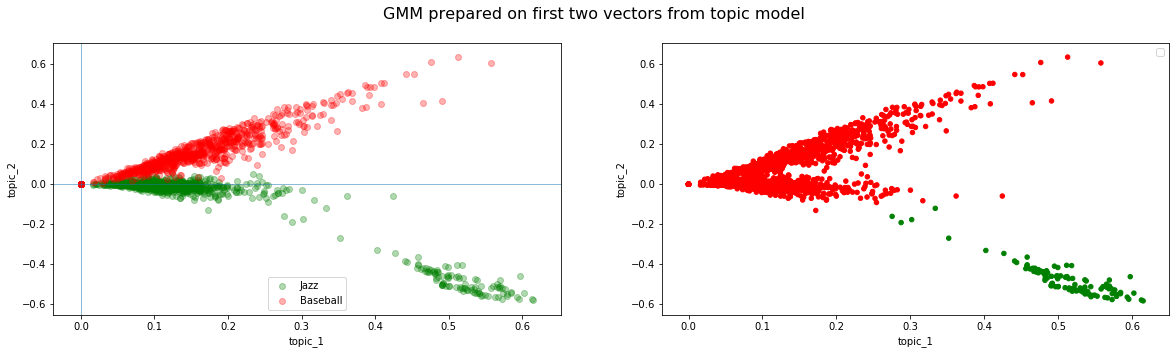

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(20,5))
fig.suptitle('GMM prepared on first two vectors from topic model', fontsize=16)
for val in topic_encoded_df.is_baseball.unique():
  topic_1 = topic_encoded_df[topic_encoded_df.is_baseball == val]['topic_1'].values
  topic_2 = topic_encoded_df[topic_encoded_df.is_baseball == val]['topic_2'].values
  print(val)
  color = "red" if val else "green"
  label = "Baseball" if val else "Jazz"
  ax[0].scatter(topic_1, topic_2, c=color, alpha=0.3, label=label)
  
topic_encoded_df.plot(kind="scatter", x="topic_1", y="topic_2", c=["red" if label == 0 else "green" for label in labels], ax=ax[1])  
# made the colors represent different books

ax[0].set_xlabel('topic_1')
ax[0].set_ylabel('topic_2')
ax[0].axvline(linewidth=0.5)
ax[0].axhline(linewidth=0.5)
ax[0].legend()
ax[1].legend()

# display(fig)

In [56]:
svd = TruncatedSVD(n_components=100)
lsa = svd.fit_transform(bag_of_words)

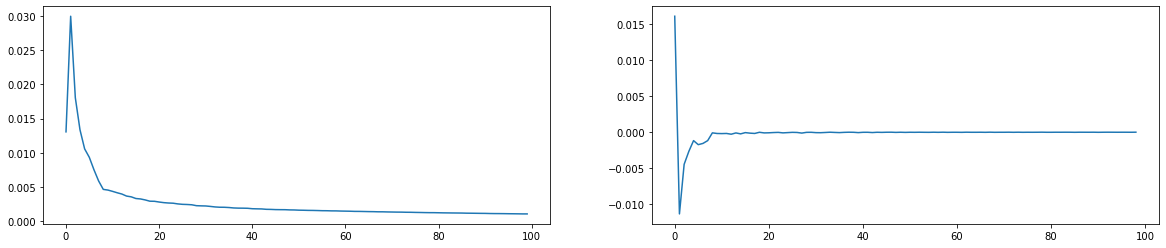

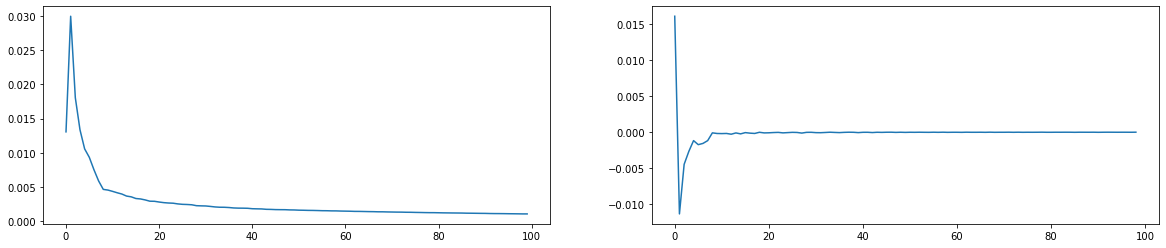

In [57]:
import numpy as np
fig, ax = plt.subplots(1,2, figsize=(20,4))
ax[0].plot(svd.explained_variance_ratio_)
ax[1].plot(np.diff(svd.explained_variance_))
display(fig)

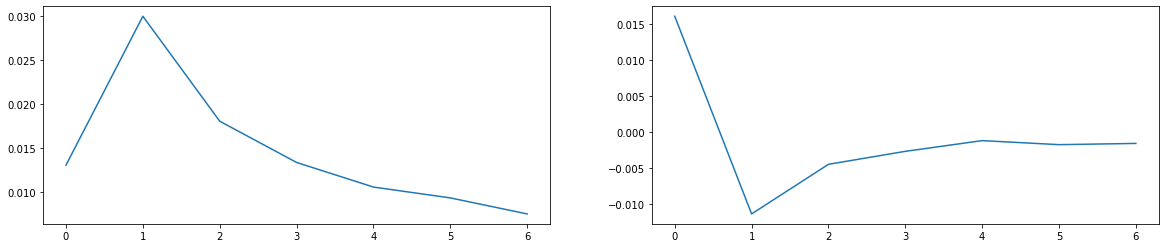

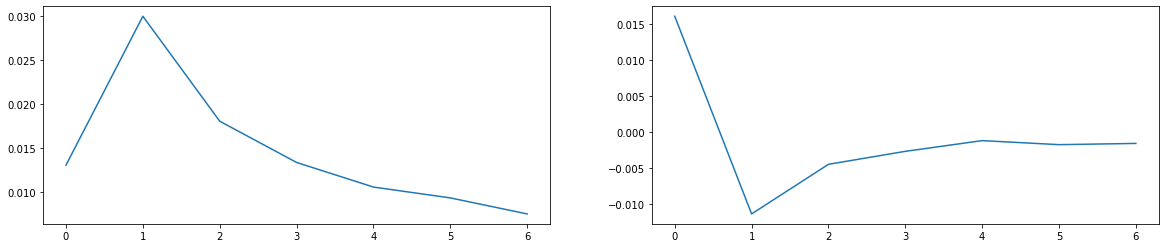

In [58]:
import numpy as np
fig, ax = plt.subplots(1,2, figsize=(20,4))
ax[0].plot(svd.explained_variance_ratio_[:7])
ax[1].plot(np.diff(svd.explained_variance_)[:7])
display(fig)

In [59]:
svd = TruncatedSVD(n_components=20)
lsa = svd.fit_transform(bag_of_words)

In [60]:
encoding_matrix = pd.DataFrame(svd.components_,
                               index=['topic_' + str(i) for i in range(1,21)],
                               columns=dictionary).T
encoding_matrix["dictionary"] = dictionary
display(encoding_matrix.head())

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,dictionary
_______,0.000190,0.000323,-0.000252,-0.000943,0.000009,-0.000082,-0.000117,-0.001887,0.000257,0.001238,...,0.001599,-0.002183,-0.000668,-0.000641,0.000676,-0.001588,0.000874,-0.002619,-0.000220,_______
__baseball,0.000089,0.000111,-0.000016,0.000302,0.000011,0.000004,-0.000042,-0.000009,0.000008,0.000244,...,-0.000084,-0.000095,0.000385,-0.000104,0.000003,0.000163,0.000384,-0.000080,0.000199,__baseball
a_,0.000211,0.000287,-0.000123,0.000152,0.000006,0.000035,0.000028,0.000759,-0.000784,-0.001882,...,0.001193,-0.001967,-0.000144,-0.000681,-0.000792,0.000649,-0.001707,0.001809,-0.000699,a_
aa,0.002082,0.002398,-0.000554,0.005282,0.000027,-0.000009,-0.000545,-0.005439,0.002531,-0.002835,...,-0.000387,-0.000088,-0.004528,0.000142,0.001935,-0.002506,-0.000138,-0.002397,0.000743,aa
aaa,0.002269,0.002774,-0.000848,0.004024,-0.000130,-0.000400,-0.000412,-0.003269,0.001384,-0.001865,...,-0.000835,0.002889,-0.004291,0.000098,0.001989,-0.002155,0.000490,-0.003473,0.000156,aaa


In [61]:
list(encoding_matrix.sort_values('topic_1', ascending=False).head(20).dictionary)

['american',
 'died',
 'jazz',
 'baseball',
 'composer',
 'born',
 'pianist',
 'league',
 'ball',
 'saxophonist',
 'game',
 'singer',
 'base',
 'music',
 'records',
 'team',
 'guitarist',
 'label',
 'pitcher',
 'batter']

In [62]:
list(encoding_matrix.sort_values('topic_2', ascending=False).head(20).dictionary)

['baseball',
 'ball',
 'base',
 'league',
 'game',
 'batter',
 'pitcher',
 'team',
 'runner',
 'home',
 'hit',
 'play',
 'pitch',
 'players',
 'run',
 'player',
 'major',
 'runs',
 'games',
 'season']

In [63]:
list(encoding_matrix.sort_values('topic_3', ascending=False).head(20).dictionary)

['jazz',
 'records',
 'label',
 'music',
 'record',
 'new',
 'released',
 'labels',
 'recordings',
 'musicians',
 'album',
 'company',
 'artists',
 'band',
 'albums',
 'recorded',
 'song',
 'blues',
 'discography',
 'founded']

In [64]:
list(encoding_matrix.sort_values('topic_4', ascending=False).head(20).dictionary)

['baseball',
 'league',
 'teams',
 'professional',
 'major',
 'team',
 'championship',
 'season',
 'series',
 'players',
 'national',
 'mlb',
 'games',
 'women',
 'world',
 'award',
 'leagues',
 'year',
 'minor',
 'museum']

In [65]:
list(encoding_matrix.sort_values('topic_5', ascending=False).head(20).dictionary)

['born',
 'norwegian',
 'composer',
 'jazz',
 'festival',
 'started',
 'guitarist',
 'th',
 'july',
 'singer',
 'pianist',
 'june',
 'saxophonist',
 'bassist',
 'drummer',
 'norway',
 'songwriter',
 'monterey',
 'moers',
 'september']

In [66]:
list(encoding_matrix.sort_values('topic_6', ascending=False).head(20).dictionary)

['jazz',
 'died',
 'glenn',
 'song',
 'miller',
 'band',
 'chord',
 'orchestra',
 'bass',
 'style',
 'new',
 'swing',
 'piano',
 'musicians',
 'guitar',
 'bebop',
 'bands',
 'isbn',
 'rhythm',
 'instruments']

In [74]:
twenty_topics = ['topic_' + str(i) for i in range(2,21)] # note that topic 1 has been removed

In [75]:
topic_encoded_df = pd.DataFrame(lsa[:, 1:], columns = twenty_topics)
topic_encoded_df["text"] = wiki_df.text
topic_encoded_df["title"] = wiki_df.title
topic_encoded_df["is_baseball"] = wiki_df.category == "Baseball"

In [76]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)
gmm.fit(topic_encoded_df[twenty_topics])
labels = gmm.predict(topic_encoded_df[twenty_topics])

False
True


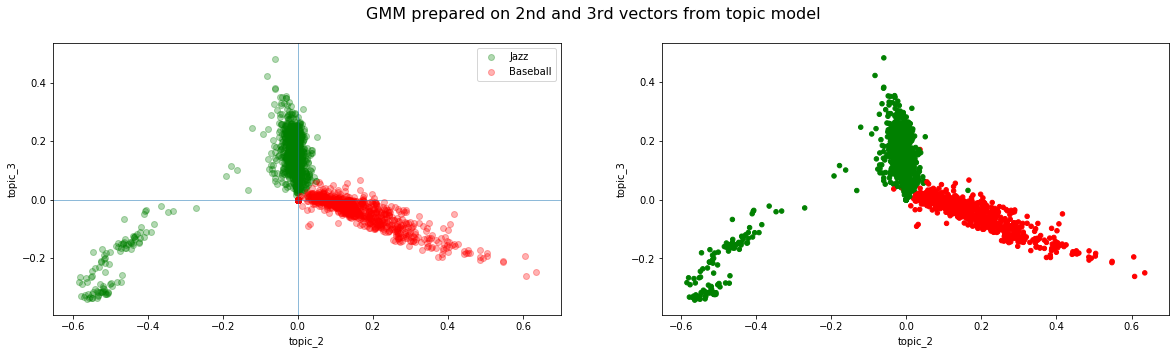

In [72]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(20,5))
fig.suptitle('GMM prepared on 2nd and 3rd vectors from topic model', fontsize=16)
for val in topic_encoded_df.is_baseball.unique():
  topic_1 = topic_encoded_df[topic_encoded_df.is_baseball == val]['topic_2'].values
  topic_2 = topic_encoded_df[topic_encoded_df.is_baseball == val]['topic_3'].values
  print(val)
  color = "red" if val else "green"
  label = "Baseball" if val else "Jazz"
  ax[0].scatter(topic_1, topic_2, c=color, alpha=0.3, label=label)
  
topic_encoded_df.plot(kind="scatter", x="topic_2", y="topic_3", c=["red" if label == 1 else "green" for label in labels], ax=ax[1])
# made the colors represent different books

ax[0].set_xlabel('topic_2')
ax[0].set_ylabel('topic_3')
ax[0].axvline(linewidth=0.5)
ax[0].axhline(linewidth=0.5)
ax[0].legend()

# display(fig)

In [44]:
fig, ax = plt.subplots(figsize=(4,4))
topic_encoded_df[labels==0].plot(kind="scatter", x="topic_2", y="topic_3", ax=ax)
display(fig)

In [45]:
jazz = topic_encoded_df[labels==0]

In [46]:
vectorizer_jazz = TfidfVectorizer(stop_words='english', preprocessor=no_number_preprocessor)
bag_of_words_jazz = vectorizer_jazz.fit_transform(jazz.text)
svd_jazz = TruncatedSVD(n_components=20)
lsa_jazz = svd_jazz.fit_transform(bag_of_words_jazz)
encoding_matrix_jazz = pd.DataFrame(svd_jazz.components_,
                               index=['topic_' + str(i) for i in range(1,21)],
                               columns=vectorizer_jazz.get_feature_names()).T
encoding_matrix_jazz["dictionary"] = vectorizer_jazz.get_feature_names()
list(encoding_matrix_jazz.sort_values('topic_1', ascending=False).head(5).dictionary)

gmm = GaussianMixture(n_components=2)
gmm.fit(jazz[twenty_topics])
jazz_labels = gmm.predict(jazz[twenty_topics])

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(10,6))

jazz.plot(kind="scatter", x="topic_2", y="topic_3", c=jazz_labels, ax=ax)
# made the colors represent different books

ax.set_xlabel('First Topic')
ax.set_ylabel('Second Topic')
ax.axvline(linewidth=0.5)
ax.axhline(linewidth=0.5)
ax.legend()

display(fig)

In [48]:
jazz_group_1 = jazz[jazz_labels == 0]
jazz_group_2 = jazz[jazz_labels == 1]

In [49]:
display(jazz_group_1[["title", "text"]].head())

title text Jazz Jazz is a music genre that originated in the African-American communities of New Orleans, United States. It originated in the late 19th and early 20th centuries, and developed from roots in blues and ragtime. Jazz is seen by many as "America's classical music". Since the 1920s Jazz Age, jazz has become recognized as a major form of musical expression. It then emerged in the form of independent traditional and popular musical styles, all linked by the common bonds of African-American and European-American musical parentage with a performance orientation. Jazz is characterized by swing and blue notes, call and response vocals, polyrhythms and improvisation. Jazz has roots in West African cultural and musical expression, and in African-American music traditions including blues and ragtime, as well as European military band music. Intellectuals around the world have hailed jazz as "one of America's original art forms".As jazz spread around the world, it drew on national, regional, and local musical cultures, which gave rise to different styles. New Orleans jazz began in the early 1910s, combining earlier brass-band marches, French quadrilles, biguine, ragtime and blues with collective polyphonic improvisation. In the 1930s, heavily arranged dance-oriented swing big bands, Kansas City jazz, a hard-swinging, bluesy, improvisational style and Gypsy jazz (a style that emphasized musette waltzes) were the prominent styles. Bebop emerged in the 1940s, shifting jazz from danceable popular music toward a more challenging "musician's music" which was played at faster tempos and used more chord-based improvisation. Cool jazz developed near the end of the 1940s, introducing calmer, smoother sounds and long, linear melodic lines.
The 1950s saw the emergence of free jazz, which explored playing without regular meter, beat and formal structures, and in the mid-1950s, hard bop emerged, which introduced influences from rhythm and blues, gospel, and blues, especially in the saxophone and piano playing. Modal jazz developed in the late 1950s, using the mode, or musical scale, as the basis of musical structure and improvisation. Jazz-rock fusion appeared in the late 1960s and early 1970s, combining jazz improvisation with rock music's rhythms, electric instruments, and highly amplified stage sound. In the early 1980s, a commercial form of jazz fusion called smooth jazz became successful, garnering significant radio airplay. Other styles and genres abound in the 2000s, such as Latin and Afro-Cuban jazz.


== Etymology and definition ==

The origin of the word jazz has resulted in considerable research, and its history is well documented. It is believed to be related to jasm, a slang term dating back to 1860 meaning "pep, energy". The earliest written record of the word is in a 1912 article in the Los Angeles Times in which a minor league baseball pitcher described a pitch which he called a "jazz ball" "because it wobbles and you simply can't do anything with it".The use of the word in a musical context was documented as early as 1915 in the Chicago Daily Tribune. Its first documented use in a musical context in New Orleans was in a November 14, 1916 Times-Picayune article about "jas bands". In an interview with NPR, musician Eubie Blake offered his recollections of the slang connotations of the term, saying, "When Broadway picked it up, they called it 'J-A-Z-Z'. It wasn't called that. It was spelled 'J-A-S-S'. That was dirty, and if you knew what it was, you wouldn't say it in front of ladies." The American Dialect Society named it the Word of the 20th Century.Jazz is difficult to define because it encompasses a wide range of music spanning a period of over 100 years, from ragtime to the rock-infused fusion. Attempts have been made to define jazz from the perspective of other musical traditions, such as European music history or African music. But critic Joachim-Ernst Berendt argues that its terms of reference and its definition shoul

In [50]:
vectorizer_1 = TfidfVectorizer(stop_words='english', preprocessor=no_number_preprocessor)
vectorizer_2 = TfidfVectorizer(stop_words='english', preprocessor=no_number_preprocessor)
bag_of_words_jazz_1 = vectorizer_1.fit_transform(jazz_group_1.text)
bag_of_words_jazz_2 = vectorizer_2.fit_transform(jazz_group_2.text)

In [51]:
svd_1 = TruncatedSVD(n_components=20)
lsa = svd_1.fit_transform(bag_of_words_jazz_1)
encoding_matrix_1 = pd.DataFrame(svd_1.components_,
                               index=['topic_' + str(i) for i in range(1,21)],
                               columns=vectorizer_1.get_feature_names()).T
encoding_matrix_1["dictionary"] = vectorizer_1.get_feature_names()
list(encoding_matrix_1.sort_values('topic_1', ascending=False).head(5).dictionary)

Out[38]: ['jazz', 'records', 'label', 'music', 'new']

In [52]:
svd_2 = TruncatedSVD(n_components=20)
lsa = svd_2.fit_transform(bag_of_words_jazz_2)
encoding_matrix_2 = pd.DataFrame(svd_2.components_,
                               index=['topic_' + str(i) for i in range(1,21)],
                               columns=vectorizer_2.get_feature_names()).T
encoding_matrix_2["dictionary"] = vectorizer_2.get_feature_names()
list(encoding_matrix_2.sort_values('topic_1', ascending=False).head(5).dictionary)

Out[39]: ['american', 'died', 'born', 'composer', 'pianist']

In [53]:
print(list(encoding_matrix_1.sort_values('topic_1', ascending=False).head(5).dictionary))
print(list(encoding_matrix_1.sort_values('topic_2', ascending=False).head(5).dictionary))
print(list(encoding_matrix_1.sort_values('topic_3', ascending=False).head(5).dictionary))
print(list(encoding_matrix_1.sort_values('topic_4', ascending=False).head(5).dictionary))
print(list(encoding_matrix_1.sort_values('topic_5', ascending=False).head(5).dictionary))
print(list(encoding_matrix_1.sort_values('topic_6', ascending=False).head(5).dictionary))
print(list(encoding_matrix_1.sort_values('topic_7', ascending=False).head(5).dictionary))
print(list(encoding_matrix_1.sort_values('topic_8', ascending=False).head(5).dictionary))
print(list(encoding_matrix_1.sort_values('topic_9', ascending=False).head(5).dictionary))
print(list(encoding_matrix_1.sort_values('topic_10', ascending=False).head(5).dictionary))

['jazz', 'records', 'label', 'music', 'new']
['glenn', 'miller', 'song', 'jazz', 'orchestra']
['glenn', 'miller', 'records', 'orchestra', 'label']
['chord', 'bass', 'chords', 'scale', 'used']
['song', 'recorded', 'dixieland', 'whiteman', 'parker']
['album', 'award', 'chet', 'best', 'winners']
['chord', 'parker', 'chords', 'scale', 'jazz']
['chord', 'dixieland', 'orleans', 'jazz', 'chords']
['chet', 'baker', 'music', 'rca', 'emi']
['chet', 'baker', 'jazz', 'bass', 'discography']

In [54]:
print(list(encoding_matrix_2.sort_values('topic_1', ascending=False).head(5).dictionary))
print(list(encoding_matrix_2.sort_values('topic_2', ascending=False).head(5).dictionary))
print(list(encoding_matrix_2.sort_values('topic_3', ascending=False).head(5).dictionary))
print(list(encoding_matrix_2.sort_values('topic_4', ascending=False).head(5).dictionary))
print(list(encoding_matrix_2.sort_values('topic_5', ascending=False).head(5).dictionary))
print(list(encoding_matrix_2.sort_values('topic_6', ascending=False).head(5).dictionary))
print(list(encoding_matrix_2.sort_values('topic_7', ascending=False).head(5).dictionary))
print(list(encoding_matrix_2.sort_values('topic_8', ascending=False).head(5).dictionary))
print(list(encoding_matrix_2.sort_values('topic_9', ascending=False).head(5).dictionary))
print(list(encoding_matrix_2.sort_values('topic_10', ascending=False).head(5).dictionary))

['american', 'died', 'born', 'composer', 'pianist']
['born', 'started', 'norwegian', 'composer', 'festival']
['isbn', 'real', 'book', 'volume', 'leonard']
['norwegian', 'fusion', 'jazz', 'composer', 'december']
['jazz', 'isbn', 'real', 'book', 'volume']
['american', 'losen', 'ecm', 'concord', 'corea']
['best', 'performance', 'composer', 'awarded', 'sun']
['started', 'festival', 'composer', 'th', 'concord']
['saxophonist', 'losen', 'ecm', 'concord', 'mathisen']
['born', 'records', 'recorded', 'standard', 'movie']